In [ ]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import torch
import torchvision
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Load data

In [ ]:
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
val_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Generate with underlying distribution directly

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data))
x, y = next(iter(train_loader))

In [ ]:
def parameterized_truncated_normal(uniform, mu, sigma, a=0, b=255):
    mu = mu.cpu()
    sigma = sigma.cpu()
    normal = torch.distributions.normal.Normal(0, 1)
    #normal = torch.distributions.normal.Normal(0, 1)
    aa = torch.full(mu.shape,a)
    bb = torch.full(sigma.shape,b)
    alpha = (aa - mu) / sigma
    beta = (bb - mu) / sigma

    alpha_normal_cdf = normal.cdf(alpha)
    p = alpha_normal_cdf + (normal.cdf(beta) - alpha_normal_cdf) * uniform
    print("shape of p is ", p.shape())
    p = p.numpy()
    one = np.ones(p.shape, dtype=p.dtype)
    epsilon = np.full(p.shape, np.finfo(p.dtype).eps, dtype=p.dtype)
    v = np.clip(2 * p - 1, -one + epsilon, one - epsilon)
    x = mu + sigma * np.sqrt(2) * torch.erfinv(torch.from_numpy(v))
    x = torch.clamp(x, a, b)

    return x


def truncated_normal(uniform):
    return parameterized_truncated_normal(uniform, mu=0.0, sigma=1.0, a=-2, b=2)


def sample_truncated_normal(shape=()):
    return truncted_normal(torch.from_numpy(np.random.uniform(0, 1, shape)))

In [ ]:
h, w = x.shape[2], x.shape[3]
dists = []
dists_ =[]
eps = 1e-4  # incase var = 0
means = torch.zeros(len(train_data.classes), h, w)
vars = torch.ones(len(train_data.classes), h, w) * eps
normmeans = torch.zeros(len(train_data.classes), h, w)
normvars = torch.ones(len(train_data.classes), h, w) * eps
for digit in range(len(train_data.classes)):
    subset = x[torch.where(y == digit)[0], :, :]
    #print(subset.shape)
    means[digit, :, :] = torch.mean(subset, dim=0).squeeze(0)
    vars[digit, :, :] += torch.var(subset, dim=0).squeeze(0)
    normx = (x-means)/vars
    normsubset = x[torch.where(y == digit)[0], :, :]
    normmeans[digit, :, :] = torch.mean(normsubset, dim=0).squeeze(0)
    normvars[digit, :, :] += torch.var(normsubset, dim=0).squeeze(0)
    dists.append(MultivariateNormal(means[digit, :, :].reshape(-1).to(device),
                                    torch.diag(vars[digit, :, :].reshape(-1).to(device))))
    dists_.append({"mean":normmeans[digit, :, :].reshape(-1).to(device),
                                    "diag":normvars[digit, :, :].reshape(-1).to(device)})

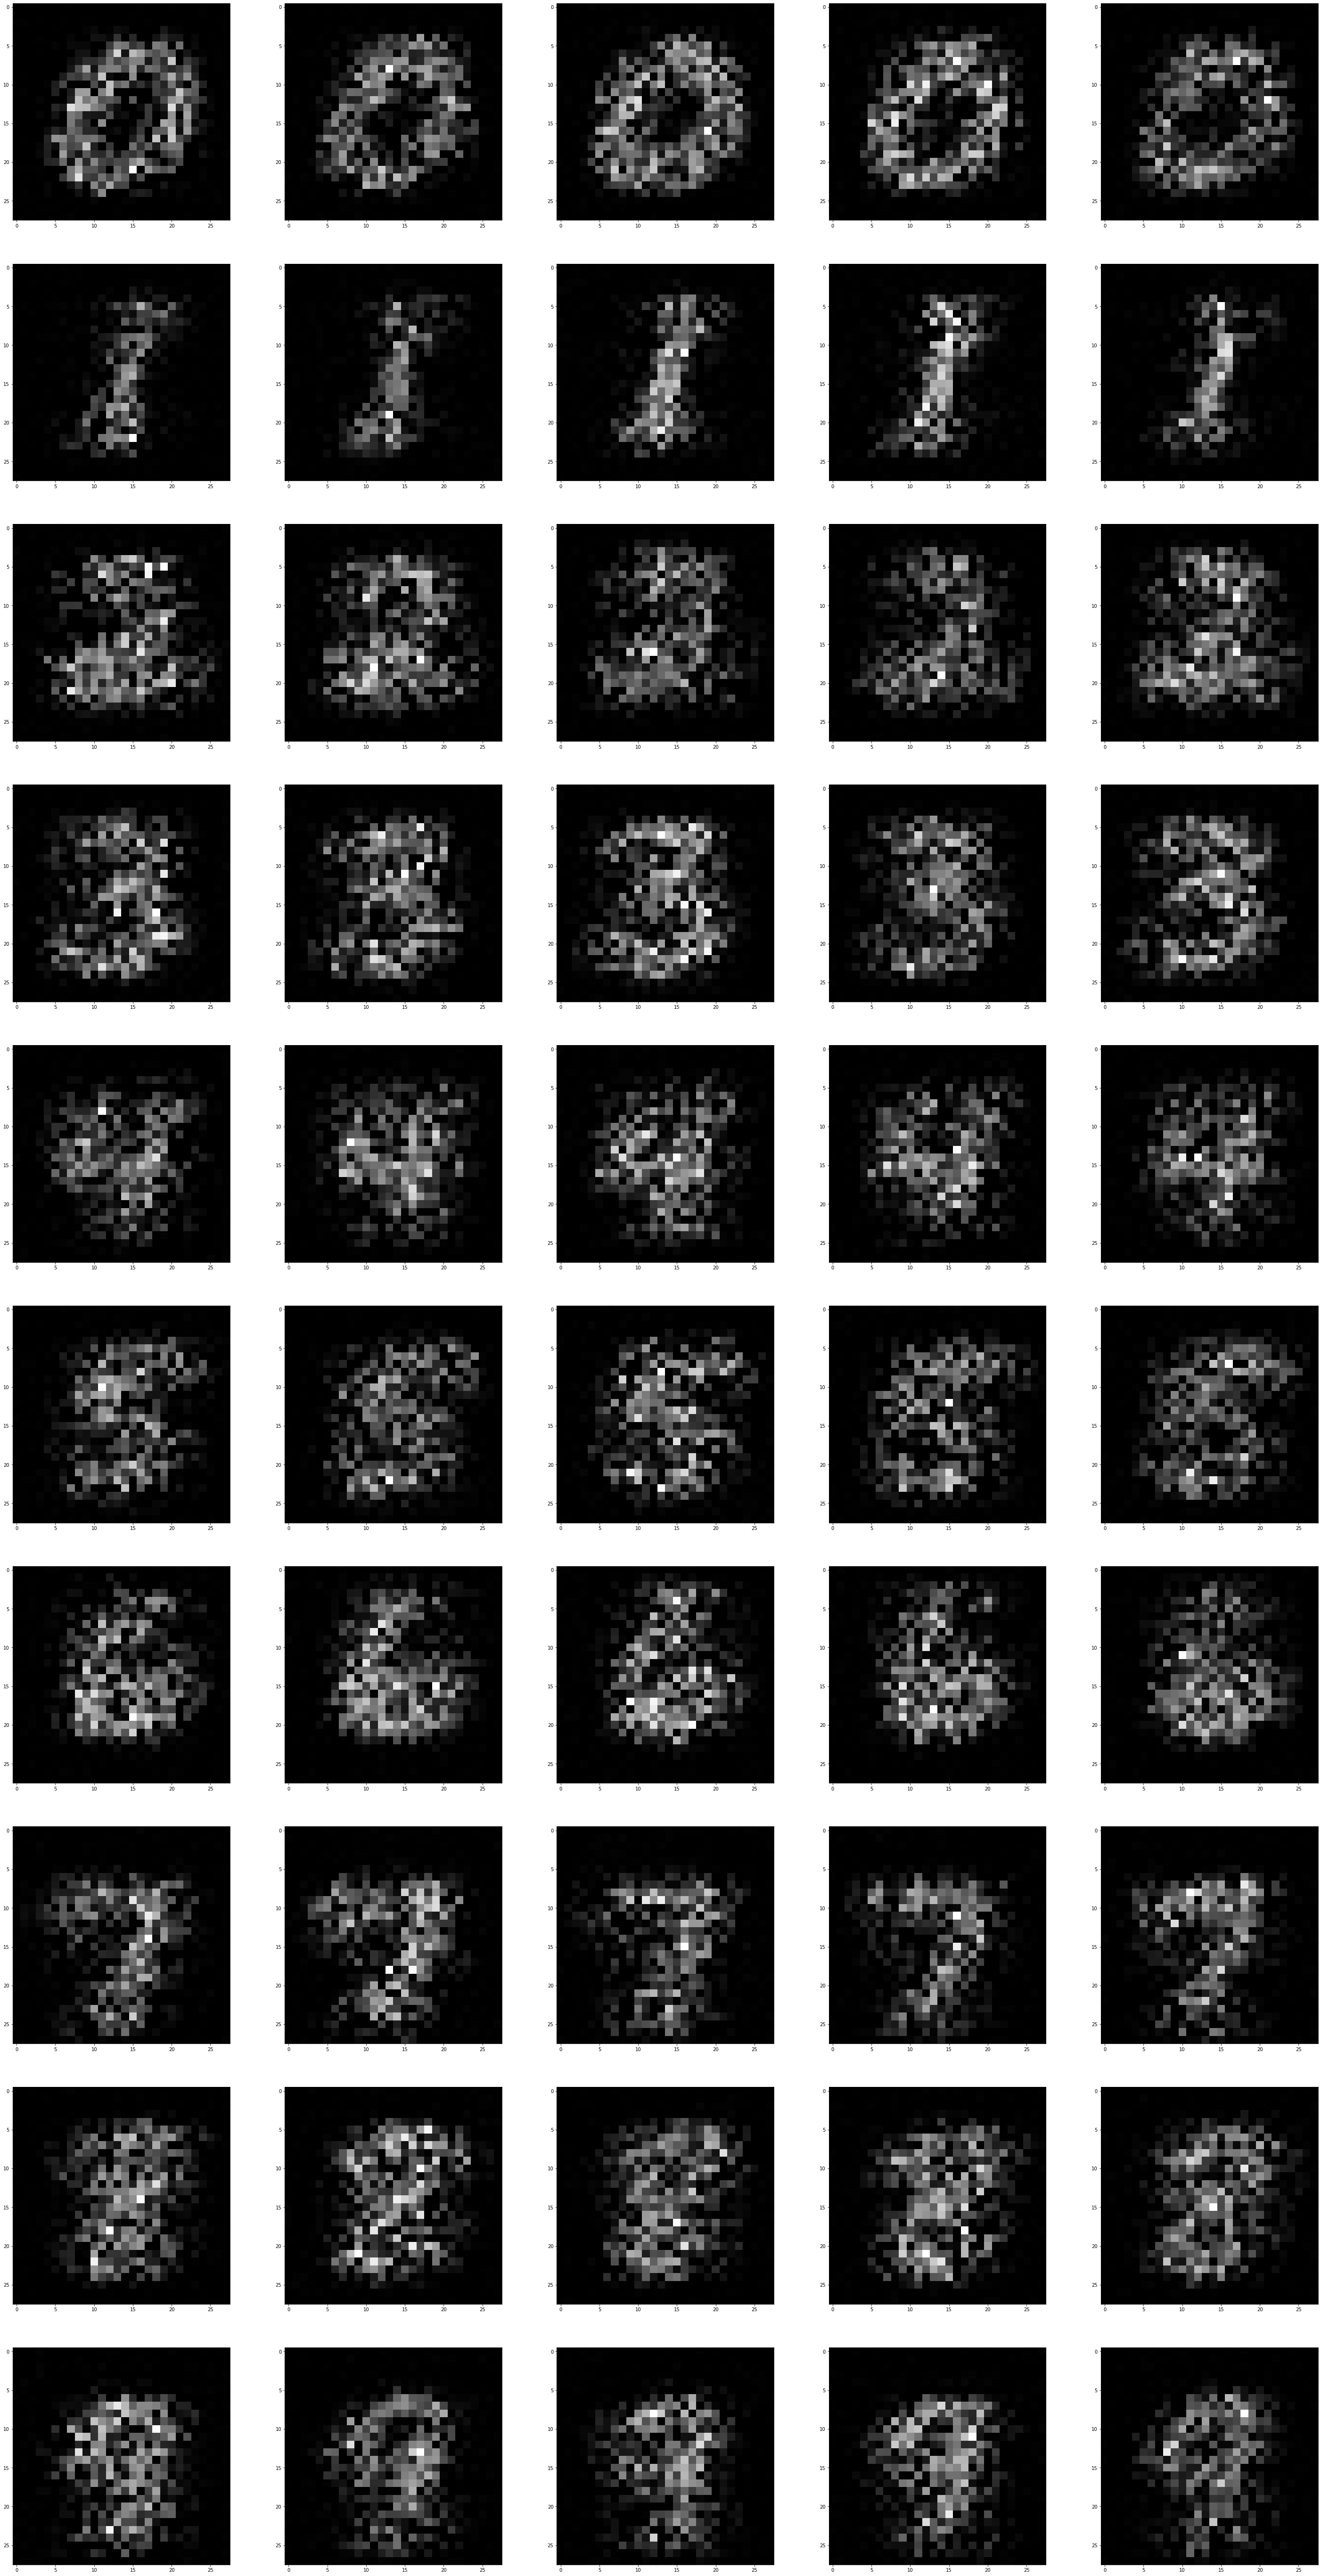

In [ ]:
num_per_class = 5

fig=plt.figure(figsize=(50,100))

for d in range(10):
    imgs = dists[d].sample(torch.Size([num_per_class])).reshape(-1, h, w).cpu().numpy()
    imgs[imgs < 0] = 0
    imgs[imgs > 255] = 255
    for i in range(num_per_class):
        # img = torchvision.transforms.ToPILImage()(imgs[i, :, :])
        fig.add_subplot(10, num_per_class, d * num_per_class + i + 1)
        plt.imshow(imgs[i, :, :], cmap='gray')

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


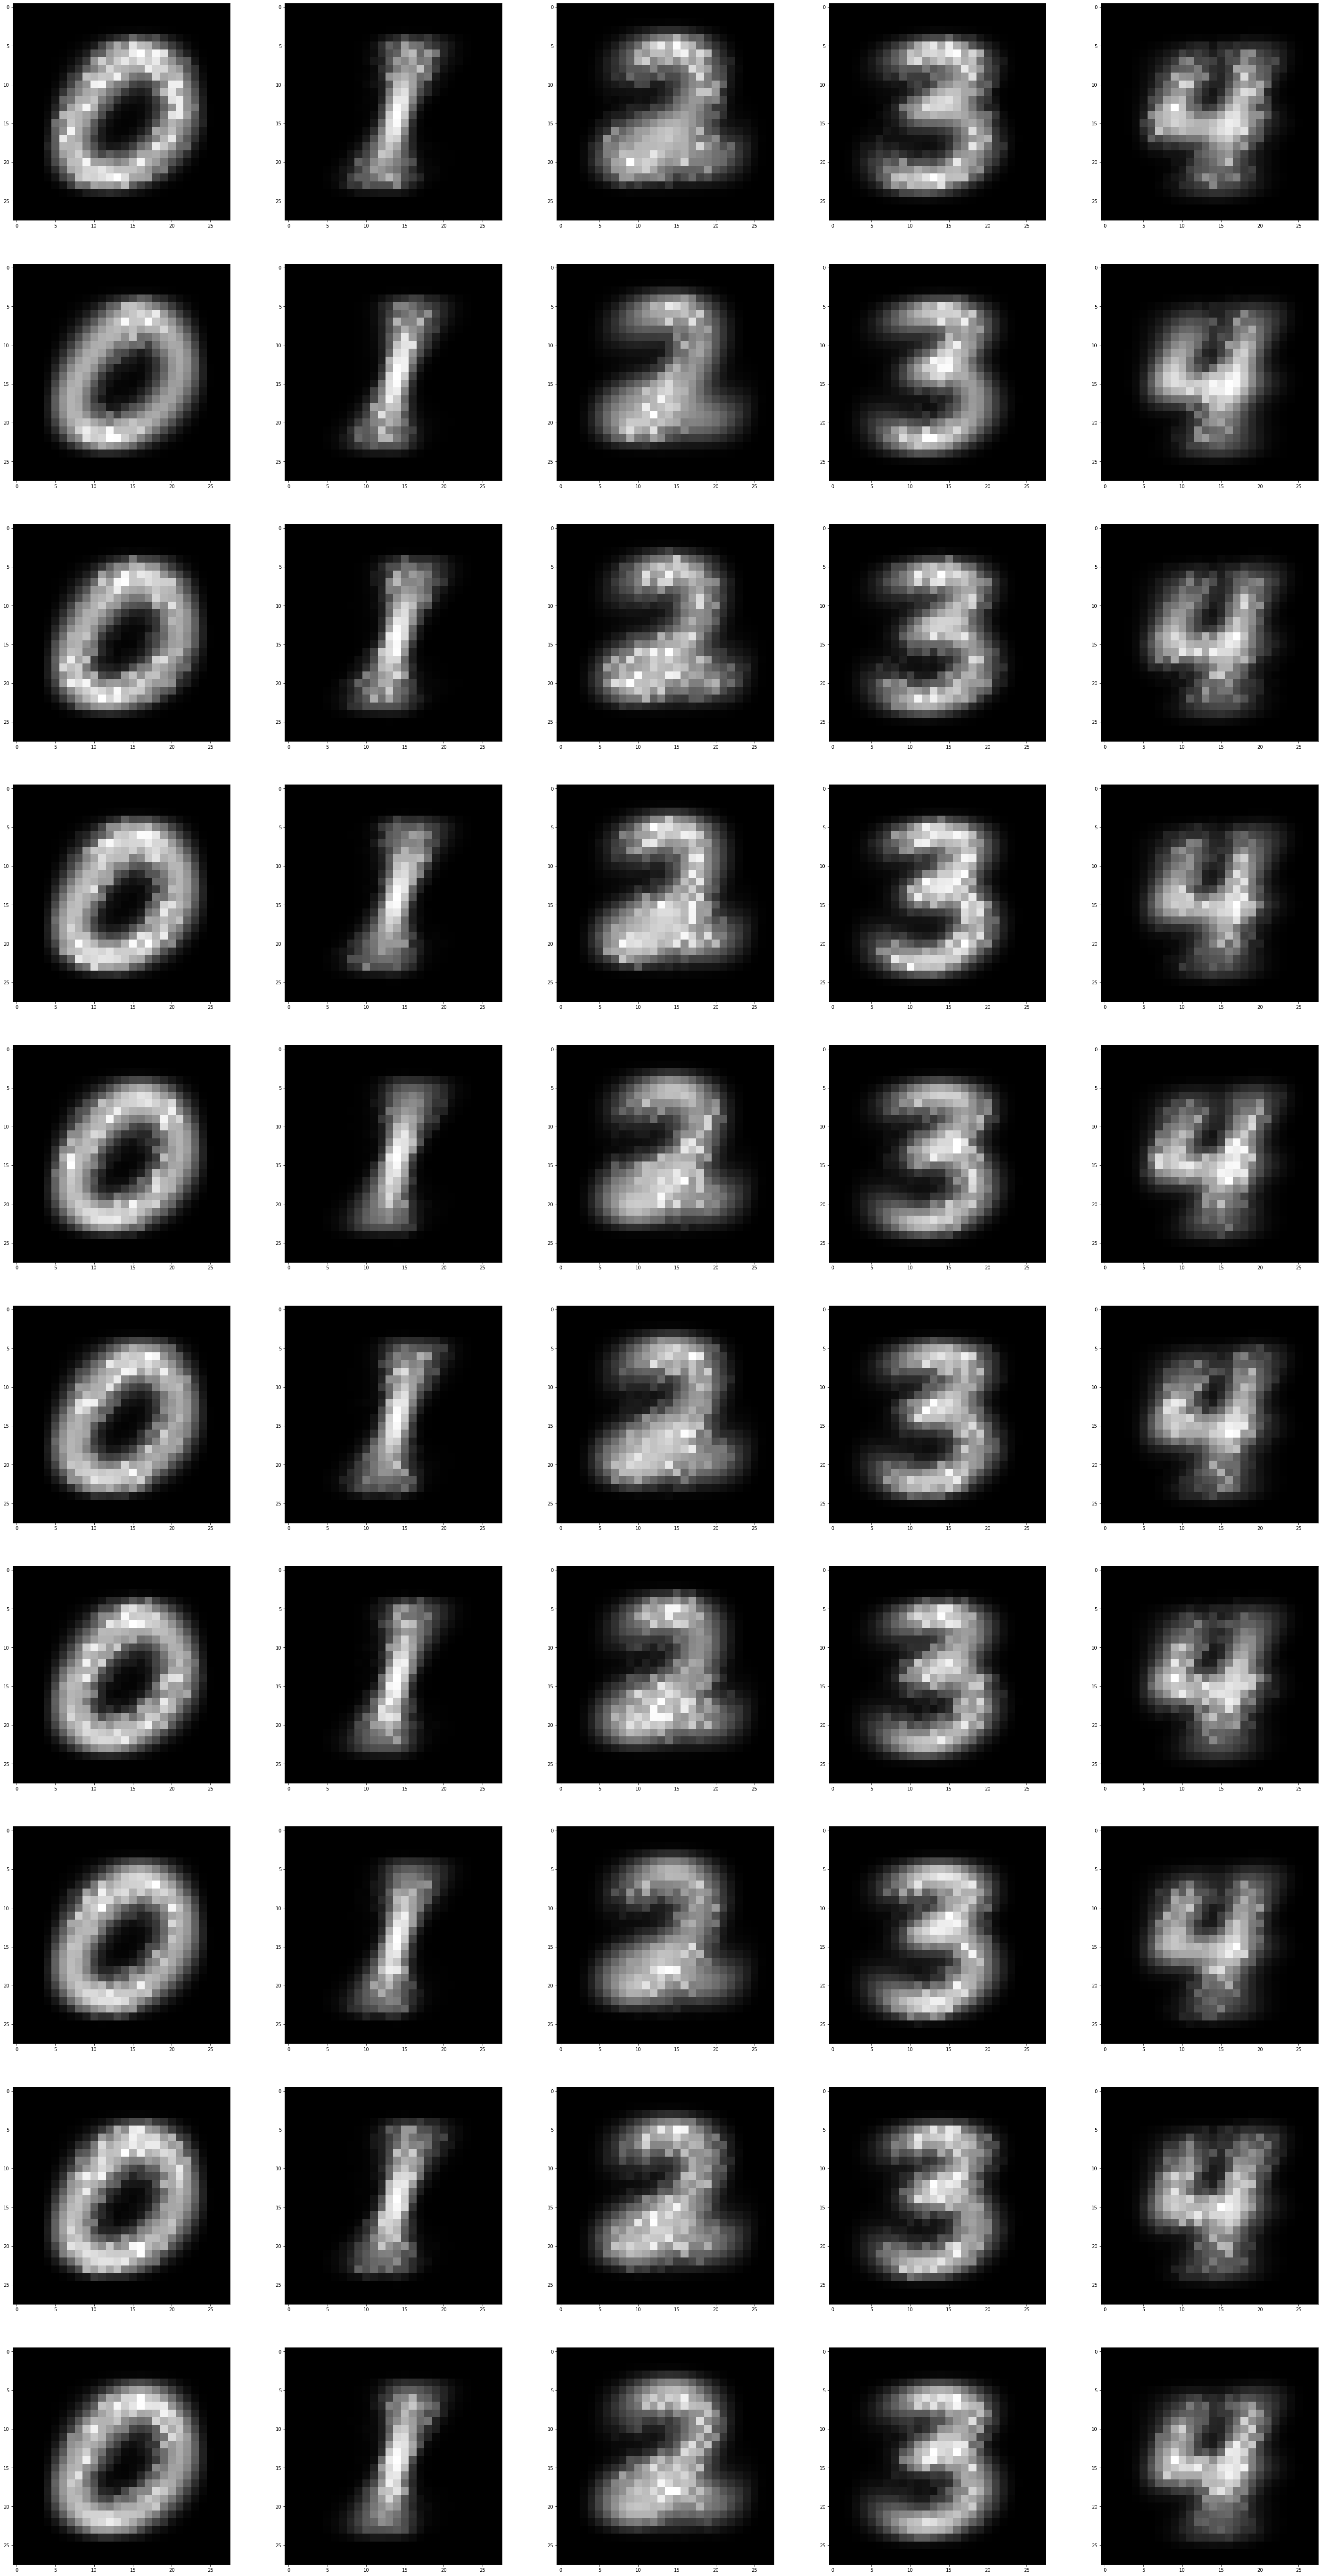

In [ ]:
num_per_class = 5

fig=plt.figure(figsize=(50,100))

for d in range(10):
    for ts in range(5):
        imgs = parameterized_truncated_normal(MultivariateNormal(torch.zeros_like(means[0].reshape(-1)),
                                    torch.diag(torch.ones_like(normvars[0].reshape(-1)))).sample(),dists_[d]["mean"],
                                              dists_[d]["diag"],0,255).reshape(-1, h, w)
        imgs = imgs * normvars + normmeans
        imgs = imgs.cpu().numpy()
    #imgs[imgs < 0] = 0
        for i in range(num_per_class):
        # img = torchvision.transforms.ToPILImage()(imgs[i, :, :])
            fig.add_subplot(10, num_per_class, d * num_per_class + i + 1)
            plt.imshow(imgs[i, :, :], cmap='gray')

# Reset dataloader

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

# Try NF with unit Gaussian as base distribution here

In [ ]:
from model import RealNVP

mask = np.indices((28, 28)).sum(axis=0) % 2
mask = mask.reshape(-1)
mask = torch.from_numpy(mask).to(device)
base_dist = MultivariateNormal(torch.zeros(28 * 28).to(device),
                               torch.eye(28 * 28).to(device))
model = RealNVP(mask, base_dist).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#TODO: seems log(p_x) and log_det_inv_j would be large negative number. e.g. -1e04

In [ ]:
epochs = 10
print_every = 1

for epoch in range(epochs):
    total_loss = 0
    for data in train_loader:
        x, _ = data
        x = (0.05 + (1 - 0.05)*x/255).to(device)
        optimizer.zero_grad()
        loss = - torch.sum(model.log_prob(x)) / x.shape[0]
        loss.backward()
        optimizer.step()
        total_loss += loss
        # print(loss)
    total_loss /= len(train_loader)

    if epoch % print_every == 0:
        print(f"Epoch {epoch} -> loss: {total_loss.item():.2f}")